# Transferencia de Aprendizaje y Ajuste Fino

## Fundamentos

Las técnicas de transferencia de conocimiento (transfer learning) y ajuste fino (fine tuning) hacen referencia a tomar parte de un modelo que fue entrenado bajo ciertas condiciones y aplicarlo en nuevas condiciones.

<br>
<center>
    <img src="figures/intro-transfer-1.png" width="800"/>
</center>

<center>
    <img src="figures/tl-1.png" width="1000"/>
</center>

<center>
    <img src="figures/tl-ft-1.png" width="800"/>
</center>


## Aplicaciones y casos de uso

1. **Adaptar un modelo de reconocimiento general de objetos para reconocer objetos específicos**
    - Modelo de reconocimiento de letras como base de modelo para reconocer dígitos
    - Modelo de reconocimiento de figuras geométricas como base de modelo para reconocer signos de tránsito
    - Modelo de reconocimiento de rostros como base de modelo para reconocer "mi" rostro


2. **Ajustar un modelo entrenado con datos ajenos a los datos con los que se utilizará**
    - Modelo entrenado con datos de la máquina A se ajusta para ahora usarlo en la máquina B
    - Modelo entrenado con datos de la máquina A bajo determinadas condiciones de operación, ahora se ajusta para usarlo bajo otras nuevas condiciones de operación

3. **Entrenar un modelo con muy pocos datos a partir de datos similares o datos sintéticos**
    - Usar banco de datos de vibraciones de rodamientos para entrenar modelo de detección de fallas de un rodamiento nuevo del que no hay datos
    - A partir de simulaciones CFD, entrenar modelo que permita predecir variables de un sistema hidráulico con pocos datos
    - Generar imágenes artificiales para entrenar modelo de reconocimiento de objetos 

# Caso de Estudio

Utilizaremos las técnicas de transferencia de conocimiento y ajuste fino para generar modelo que permita diferenciar entre manzanas rojas y verdes en una situación de escasez de datos.

El desafío consiste en usar solo 4 fotos reales para clasificar correctamente 14 otras fotos.

<br>
<center>
    <img src="figures/apple.jpeg" width="600"/>
</center>



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import scipy

In [6]:
def create_model(input_shape=(128, 128, 3)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def OLDcreate_data_generators(train_dir, val_dir, batch_size=32):
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=batch_size, class_mode='binary')

    val_generator = val_datagen.flow_from_directory(val_dir, target_size=(128, 128), batch_size=batch_size, class_mode='binary')
    return train_generator, val_generator

def create_data_generator(mydir, batch_size):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(mydir, target_size=(128, 128), batch_size=batch_size, class_mode='binary')
    return generator


## Modelo entrenado con solo 4 fotos reales

In [18]:
train_dir = 'others/real_apples_4' 

model_1 = create_model()
model_1.summary()

train_generator = create_data_generator(mydir=train_dir, batch_size=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

model_1.fit(train_generator, epochs=10, validation_data=None, verbose=1)




Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Found 4 images belonging to 2 classes.
{0: 'green', 1: 'red'}
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5667 - loss: 1.0894
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7333 - loss: 0.6395
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 0.8181
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4333 - loss: 0.7207    
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5667 - loss: 0.6705
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8333 - loss: 0.6477
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7333 - loss: 0.6503
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4333 - loss: 0.6017    
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7333 - loss: 0.5006
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8333 - loss: 0.3304


(1, 128, 128, 3)


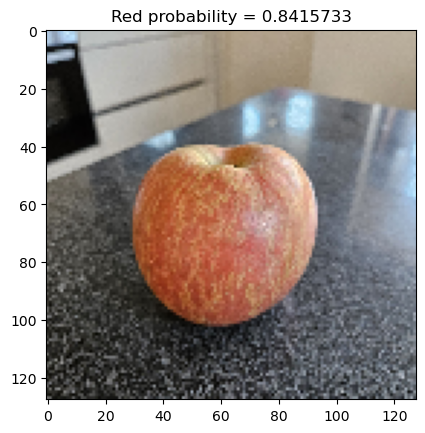

(1, 128, 128, 3)


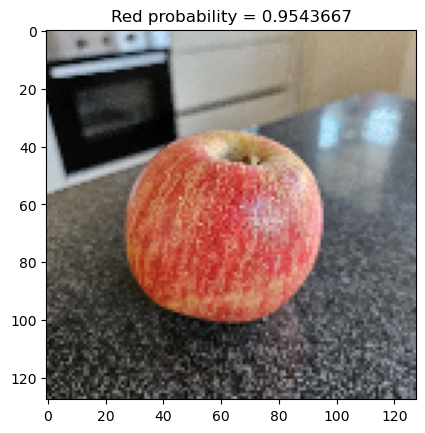

(1, 128, 128, 3)


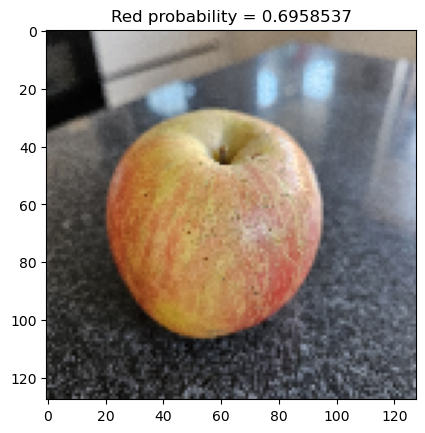

(1, 128, 128, 3)


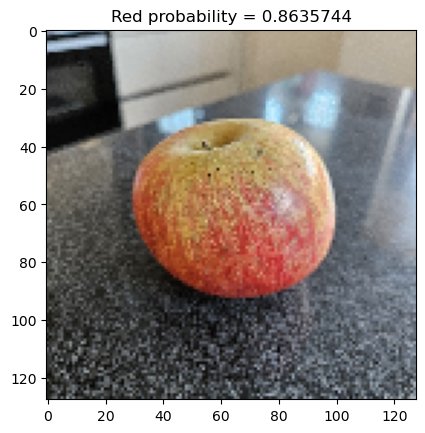

(1, 128, 128, 3)


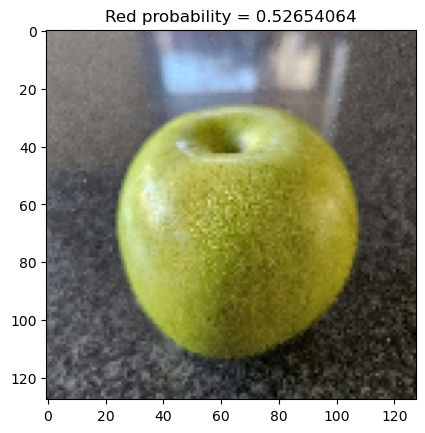

(1, 128, 128, 3)


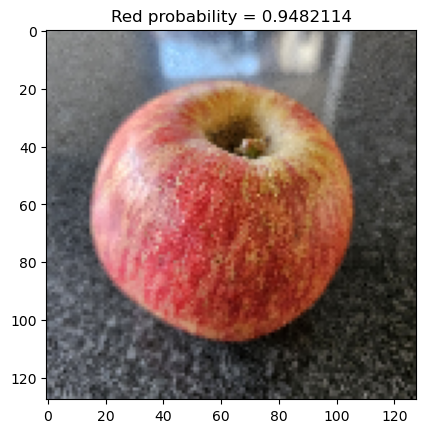

(1, 128, 128, 3)


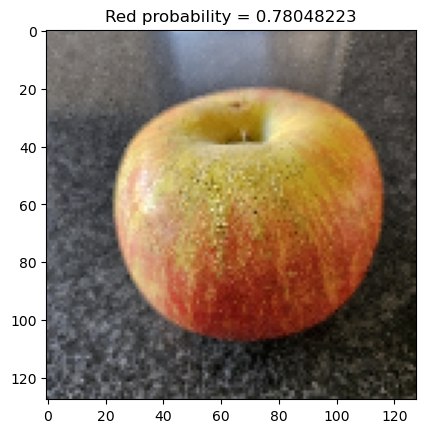

(1, 128, 128, 3)


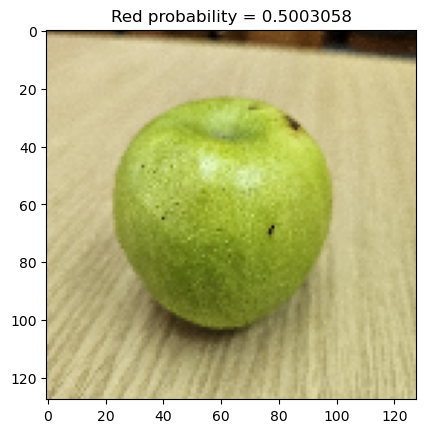

(1, 128, 128, 3)


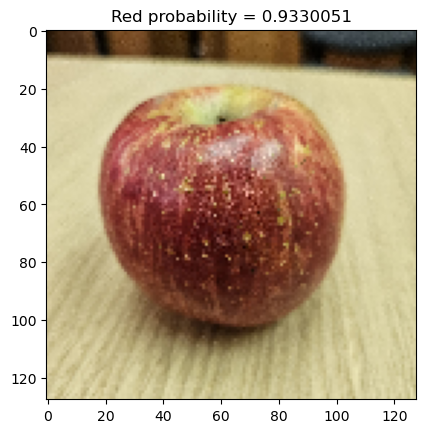

(1, 128, 128, 3)


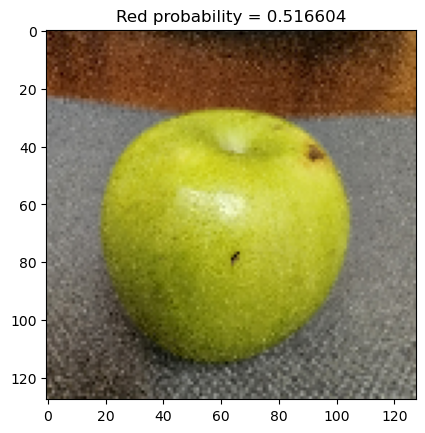

(1, 128, 128, 3)


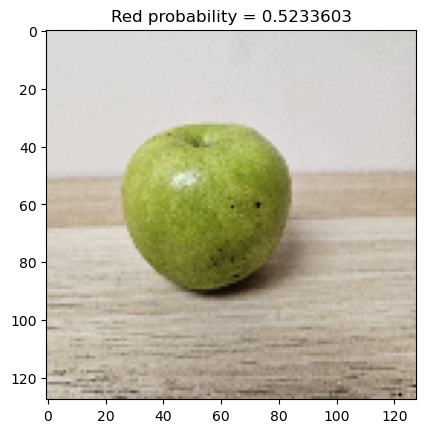

(1, 128, 128, 3)


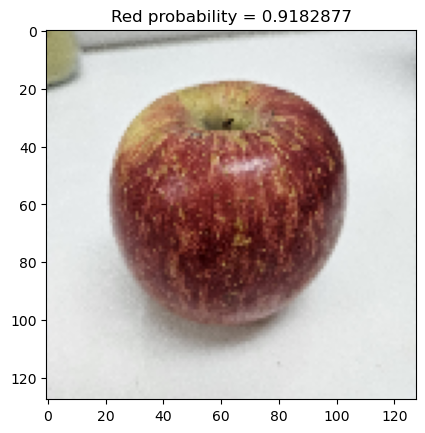

(1, 128, 128, 3)


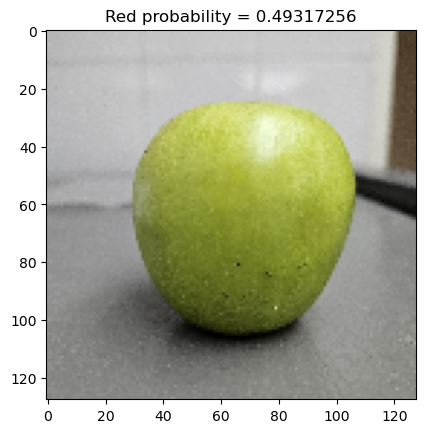

(1, 128, 128, 3)


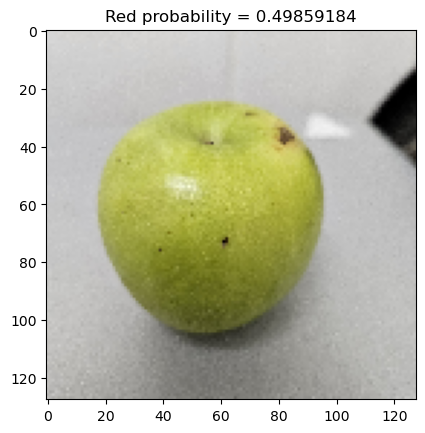

In [19]:
test_dir = 'others/real_apples_16'
for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)    
    img = load_img(file_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    print(img_array.shape)
    prediction = model_1.predict(img_array, verbose=None)[0][0]
    img = img.rotate(-90)
    plt.imshow(img)
    plt.title('Red probability = ' + str(prediction))
    plt.show()

## Modelo entrenado con fotos sintéticas

In [13]:
def generate_apple_image(color, output_path, noise_level=0.1):
    img_size = 128
    fig, ax = plt.subplots(figsize=(img_size/32, img_size/32), dpi=32)
    
    noise = np.random.normal(0.5, noise_level, (img_size, img_size, 3))
    noise = np.clip(noise, 0, 1)
    ax.imshow(noise, extent=[0, 1, 0, 1])
    
    if color == "red":
        apple_color = (np.random.uniform(0.8, 1.0), np.random.uniform(0, 0.2), np.random.uniform(0, 0.2))
    elif color == "green":
        apple_color = (np.random.uniform(0, 0.2), np.random.uniform(0.8, 1.0), np.random.uniform(0, 0.2))
    else:
        print('only red or green')
    
    diameter = np.random.uniform(0.4, 0.6)
    center_x = np.random.uniform(0.3, 0.7)
    center_y = np.random.uniform(0.3, 0.7)
    
    circle = plt.Circle((center_x, center_y), diameter/2, color=apple_color, ec="black", lw=0.5)
    ax.add_patch(circle)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")
    
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(output_path, dpi=32, bbox_inches='tight', pad_inches=0)
    plt.close()

In [15]:
os.makedirs("others/some_apple_images", exist_ok=True)

for i in range(4):
    generate_apple_image("red", f"others/some_apple_images/red_apple_{i}.png")
    generate_apple_image("green", f"others/some_apple_images/green_apple_{i}.png")

In [20]:
train_dir = 'others/fake_apples_train' 
valid_dir = 'others/fake_apples_valid' 


model_2 = create_model()
model_2.summary()

train_generator = create_data_generator(mydir=train_dir, batch_size=32)
valid_generator = create_data_generator(mydir=valid_dir, batch_size=32)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

model_2.fit(train_generator, epochs=10, validation_data=valid_generator, verbose=1)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
{0: 'green', 1: 'red'}
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.8582 - loss: 0.3135 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 1.0000 - loss: 7.7220e-05 - val_accuracy: 1.0000 - val_loss: 2.8175e-08
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 1.0000 - loss: 2.1529e-06 - val_accuracy: 1.0000 - val_loss: 1.9006e-08
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 1.0000 - loss: 9.6698e-06 - val_accuracy: 1.0000 - val_loss: 1.0551e-08
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 1.0000 - loss: 2.5856e-06 - val_accuracy: 1.0000 - val_loss: 1.1884e-08
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 1.0000 - loss: 5.3576e-07 - val_accuracy: 1.0000 - val_loss: 1.2116e-08
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 1.0000 - loss: 6.9578e

(1, 128, 128, 3)


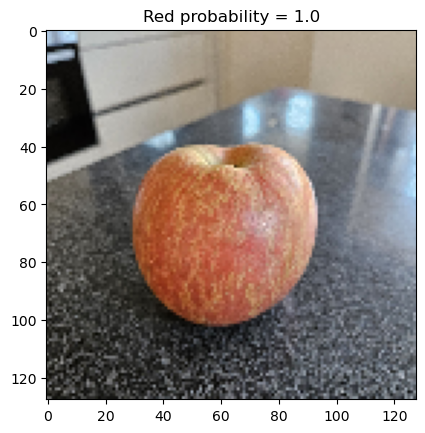

(1, 128, 128, 3)


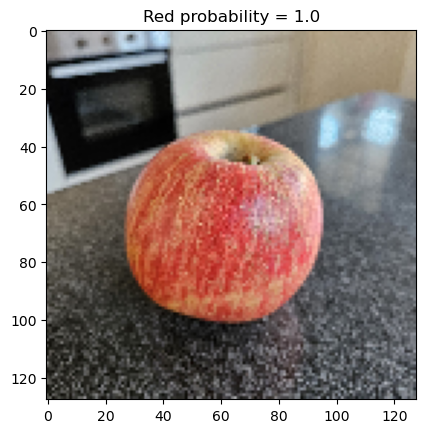

(1, 128, 128, 3)


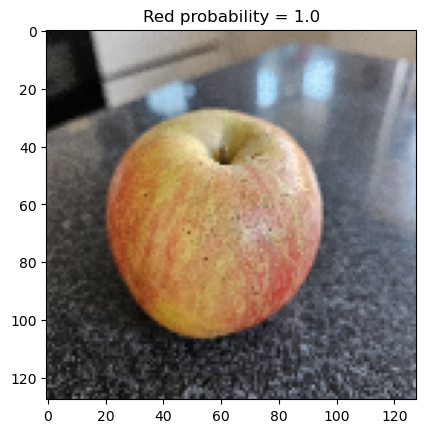

(1, 128, 128, 3)


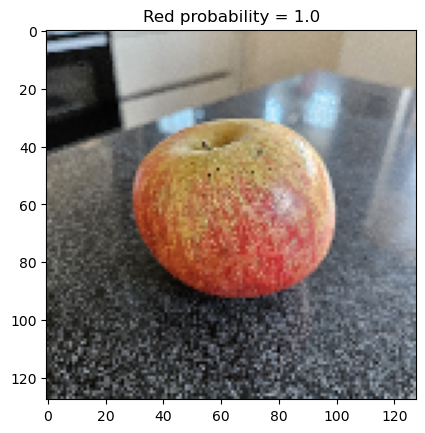

(1, 128, 128, 3)


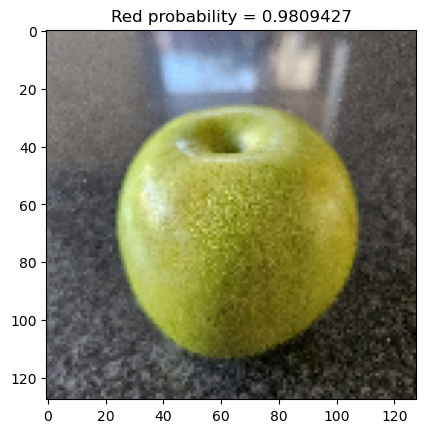

(1, 128, 128, 3)


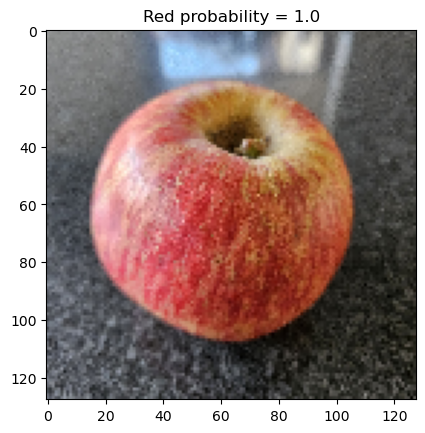

(1, 128, 128, 3)


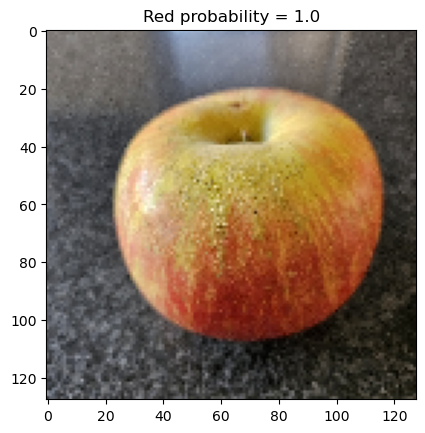

(1, 128, 128, 3)


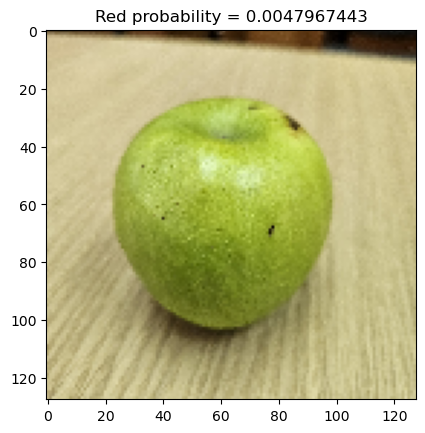

(1, 128, 128, 3)


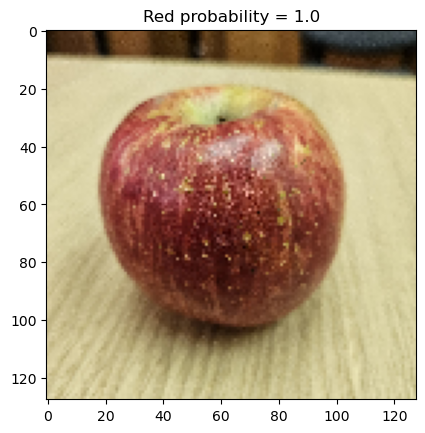

(1, 128, 128, 3)


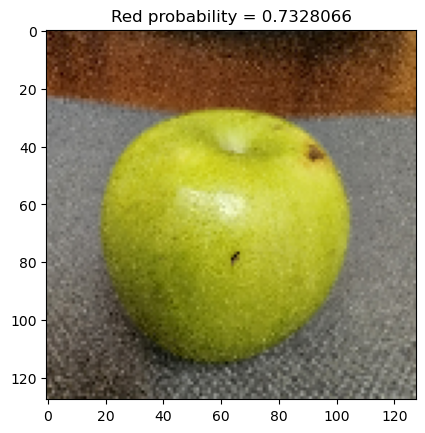

(1, 128, 128, 3)


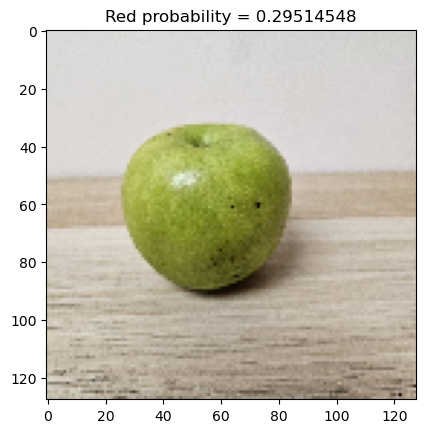

(1, 128, 128, 3)


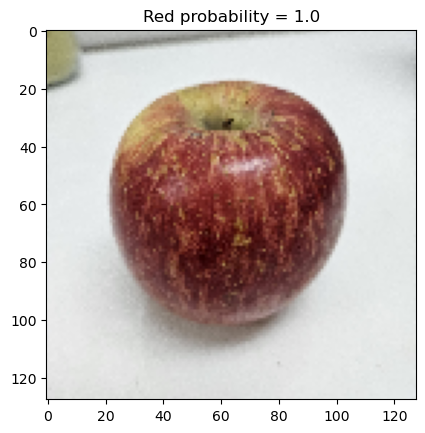

(1, 128, 128, 3)


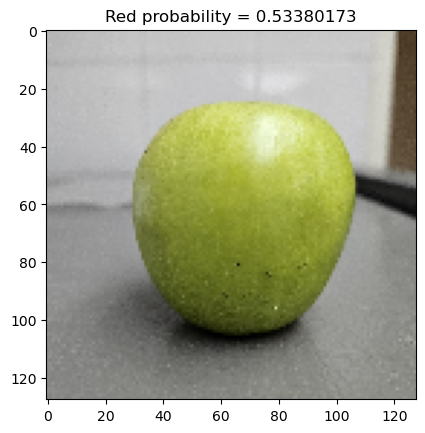

(1, 128, 128, 3)


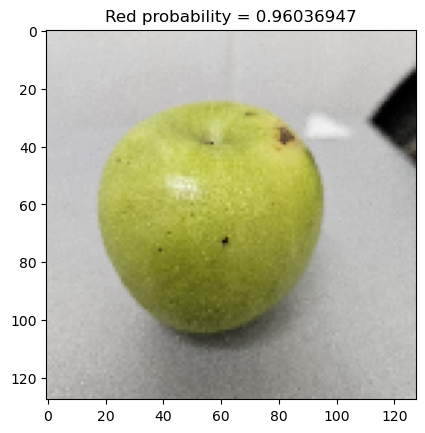

In [21]:
test_dir = 'others/real_apples_16'
for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)    
    img = load_img(file_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    print(img_array.shape)
    prediction = model_2.predict(img_array, verbose=None)[0][0]
    img = img.rotate(-90)
    plt.imshow(img)
    plt.title('Red probability = ' + str(prediction))
    plt.show()

## Ajuste fino de modelo entrenado con datos sintéticos

In [22]:
def fine_tune_model(model, train_dir, fine_tune_at, learning_rate, epochs, batch_size):

    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in model.layers[fine_tune_at:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    train_generator = create_data_generator(mydir=train_dir, batch_size=batch_size)

    model.fit(train_generator, epochs=epochs, verbose=1)

    return model

In [24]:
train_dir = "others/real_apples_4"
model_2_tuned = fine_tune_model(model_2, train_dir, fine_tune_at=-4, learning_rate=1.e-3, epochs=20, batch_size=1)

Found 4 images belonging to 2 classes.
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.1514
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.1746e-04 
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.6623e-04 
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3611e-05 
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.0542e-05 
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0020     
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.4667e-06 
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.1580e-06 
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 7.5681e-06
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 6.8078e-07
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.2273e-06

(1, 128, 128, 3)


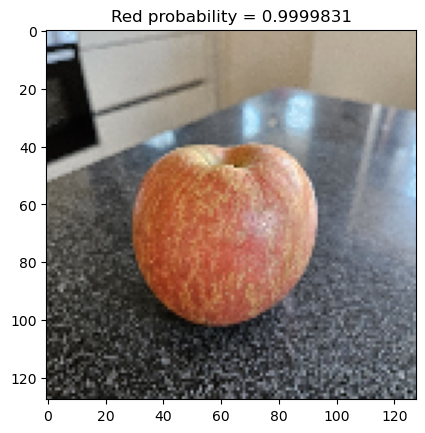

(1, 128, 128, 3)


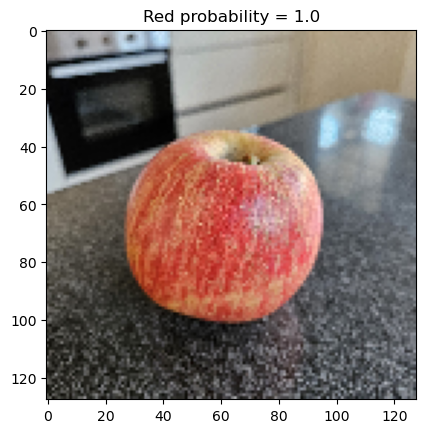

(1, 128, 128, 3)


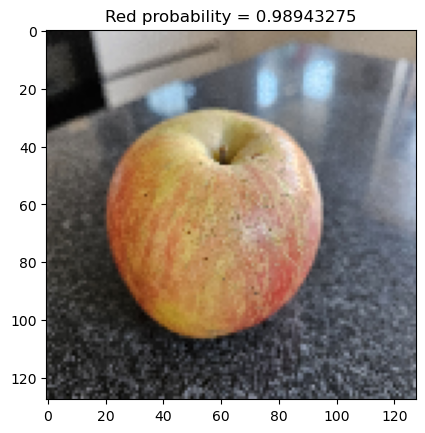

(1, 128, 128, 3)


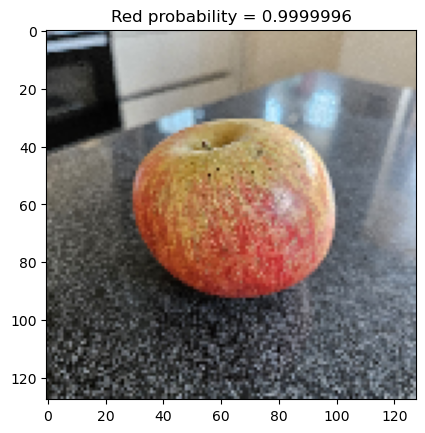

(1, 128, 128, 3)


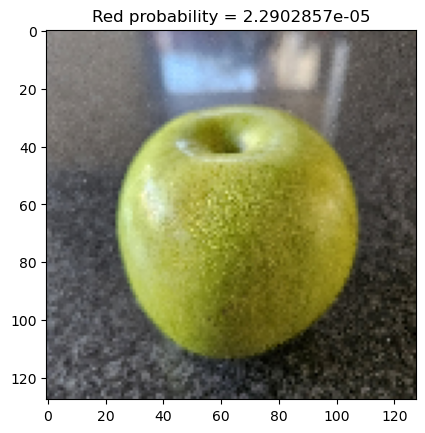

(1, 128, 128, 3)


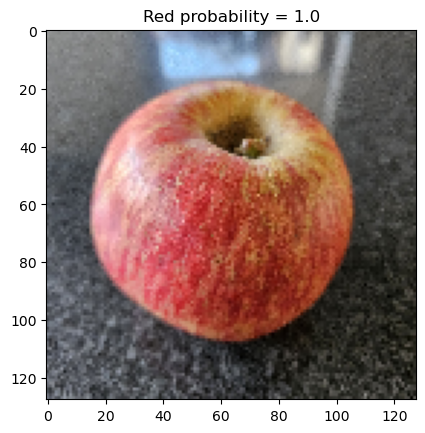

(1, 128, 128, 3)


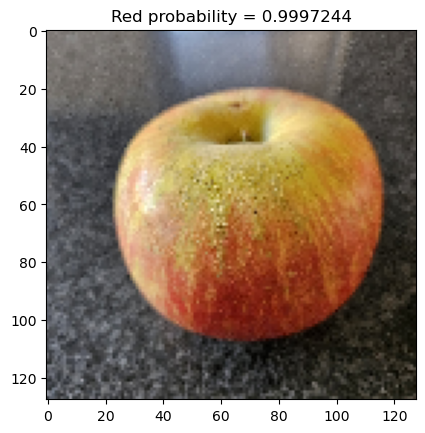

(1, 128, 128, 3)


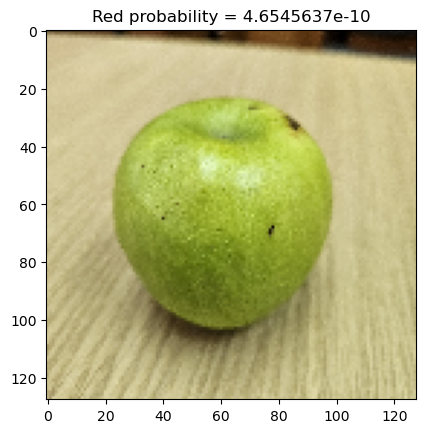

(1, 128, 128, 3)


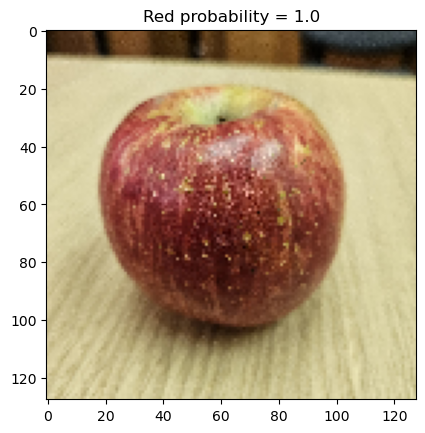

(1, 128, 128, 3)


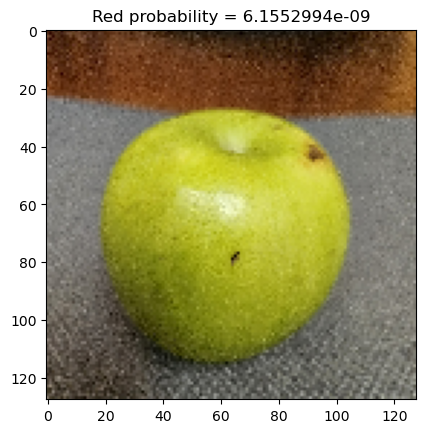

(1, 128, 128, 3)


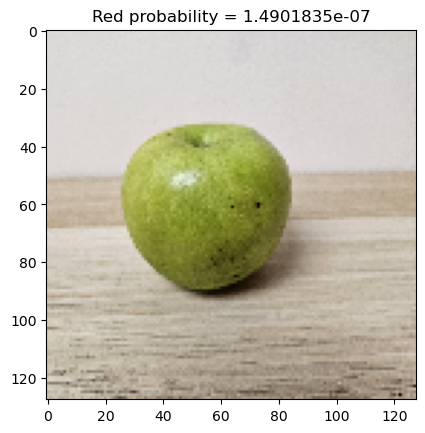

(1, 128, 128, 3)


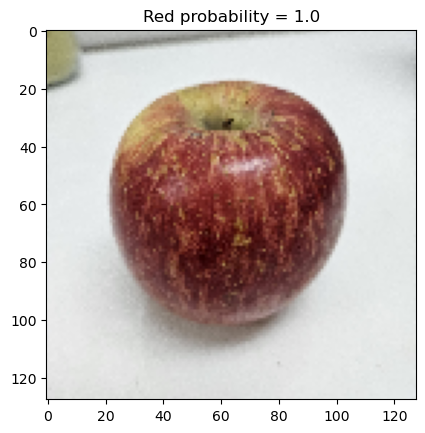

(1, 128, 128, 3)


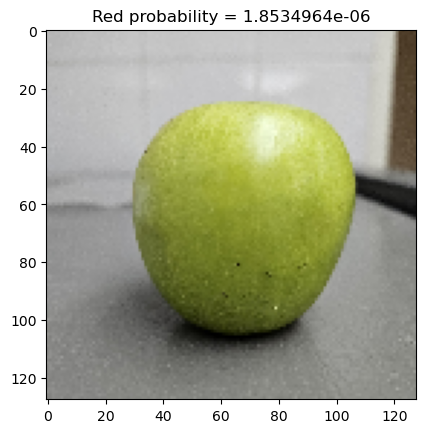

(1, 128, 128, 3)


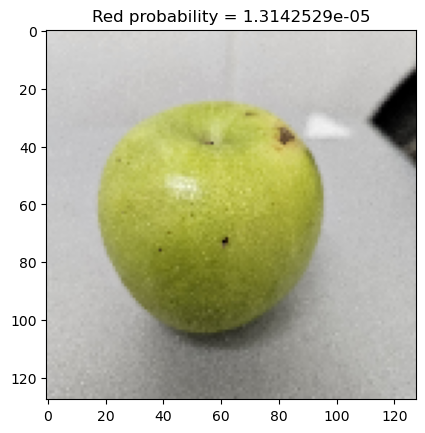

In [25]:
test_dir = 'others/real_apples_16'
for filename in os.listdir(test_dir):
    file_path = os.path.join(test_dir, filename)    
    img = load_img(file_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    print(img_array.shape)
    prediction = model_2_tuned.predict(img_array, verbose=None)[0][0]
    img = img.rotate(-90)
    plt.imshow(img)
    plt.title('Red probability = ' + str(prediction))
    plt.show()